In [1]:
import nest
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Jun 14 2024 10:44:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def run_stdp_alpha_forced_pl(config_file):
    """
    For each synapse n:
      - A single time interval train_dt_ms[n] is used for both 'input' and 'output' spike trains.
      - Pre-neuron: iaf_psc_alpha, forced by spike_generator_in.
      - Post-neuron: iaf_psc_alpha (high threshold), forced by spike_generator_out.
      - STDP synapse = stdp_pl_synapse_hom from pre -> post, with user-defined params.
      - We record spikes (pre & post) and the evolving weight.
    """

    #--------------------------------------------------------------------------
    # 1) Read YAML config
    #--------------------------------------------------------------------------
    with open(config_file, 'r') as f:
        cfg = yaml.safe_load(f)

    T_sim_ms     = cfg["T_sim_ms"]
    save_int_ms  = cfg["save_int_ms"]
    N            = cfg["N"]

    train_dt_pre_ms  = cfg["train_dt_pre_ms"]  # e.g. [100.0, 66.7, 50.0]
    offset_dt_post_ms  = cfg["offset_dt_post_ms"]  # e.g. [100.0, 66.7, 50.0]
    syn_delay    = cfg["syn_delay"]
    W0           = cfg["W0"]

    stdp_params  = cfg.get("stdp_params", {})
    forced_in_weight  = cfg.get("forced_in_weight",  1000.0)
    forced_out_weight = cfg.get("forced_out_weight", 1000.0)

    #--------------------------------------------------------------------------
    # 2) Reset and configure NEST kernel
    #--------------------------------------------------------------------------
    nest.ResetKernel()
    # e.g., nest.SetKernelStatus({"resolution": 0.1})

    #--------------------------------------------------------------------------
    # 3) Create or set stdp_pl_synapse_hom in NEST 3.7
    #
    #    We'll copy the built-in model to a custom name "my_stdp_pl_hom"
    #    with the user-provided parameters. Then we'll use "my_stdp_pl_hom" 
    #    in nest.Connect(...).
    #--------------------------------------------------------------------------
    nest.CopyModel("stdp_pl_synapse_hom", "my_stdp_pl_hom", stdp_params)

    #--------------------------------------------------------------------------
    # 4) Build the PRE-syn side (iaf_psc_alpha) for each synapse
    #--------------------------------------------------------------------------
    pre_neurons = nest.Create("iaf_psc_alpha", N)
    nest.SetStatus(pre_neurons, {
        "V_th": -10.0,   # typical threshold
        "E_L": -70.0,
        "V_reset": -70.0
    })

    #--------------------------------------------------------------------------
    # 5) Build the POST-syn side (iaf_psc_alpha) with high threshold
    #    so it won't spike unless forced by the output generator
    #--------------------------------------------------------------------------
    post_neurons = nest.Create("iaf_psc_alpha", N)
    nest.SetStatus(post_neurons, {
        "V_th": -10.0,   # artificially high
        "E_L": -70.0,
        "V_reset": -70.0
    })
    
    #    We'll forcibly drive each pre-neuron and post-neuron with a spike generator
    spike_generators_in = []

    for i in range(N):
        dt = train_dt_pre_ms[i]
        n_spikes = int(T_sim_ms // dt)
        spike_times = np.arange(10.0, n_spikes * dt, dt)

        sg_in = nest.Create("spike_generator", params={
            "spike_times": spike_times.tolist()
        })
        spike_generators_in.append(sg_in)

        # Connect input generator -> pre_neuron[i] with large weight
        nest.Connect(
            sg_in,
            pre_neurons[i],
            {"rule": "one_to_one"},
            {"synapse_model": "static_synapse", "weight": forced_in_weight, "delay": 1.0}
        )

    spike_generators_out = []
    for i in range(N):
        dt = train_dt_pre_ms[i]
        n_spikes_out = int(T_sim_ms // dt)
        spike_times_out = np.arange(10.0+offset_dt_post_ms[i], n_spikes_out * dt, dt)

        sg_out = nest.Create("spike_generator", params={
            "spike_times": spike_times_out.tolist()
        })
        spike_generators_out.append(sg_out)


        # Connect output generator -> post_neuron[i] with large weight
        nest.Connect(
            sg_out,
            post_neurons[i],
            {"rule": "one_to_one"},
            {"synapse_model": "static_synapse", "weight": forced_out_weight, "delay": 1.0}
        )

    #--------------------------------------------------------------------------
    # 6) Connect pre_neuron -> post_neuron with the custom "my_stdp_pl_hom" synapse
    #--------------------------------------------------------------------------
    connection_handles = []
    for i in range(N):
        nest.Connect(
            pre_neurons[i],
            post_neurons[i],
            {"rule": "one_to_one"},
            {
                "synapse_model": "my_stdp_pl_hom",  # The custom copy with user parameters
                "weight": W0[i],
                "delay": syn_delay[i]
            }
        )
        # Grab the connection handle for weight logging
        conn_obj = nest.GetConnections(pre_neurons[i], post_neurons[i])[0]
        connection_handles.append(conn_obj)

    #--------------------------------------------------------------------------
    # 7) Spike recorders for pre_neurons and post_neurons
    #--------------------------------------------------------------------------
    spike_rec_pre  = nest.Create("spike_recorder")
    spike_rec_post = nest.Create("spike_recorder")

    nest.Connect(pre_neurons,  spike_rec_pre,  {"rule": "all_to_all"})
    nest.Connect(post_neurons, spike_rec_post, {"rule": "all_to_all"})

    #--------------------------------------------------------------------------
    # 8) Simulation in steps, log weight changes
    #--------------------------------------------------------------------------
    current_time = 0.0
    weight_records = []

    while current_time < T_sim_ms:
        next_time = min(current_time + save_int_ms, T_sim_ms)
        nest.Simulate(next_time - current_time)
        current_time = next_time

        record_now = {"time_ms": current_time}
        for j, conn_obj in enumerate(connection_handles):
            w_val = conn_obj.get("weight")
            record_now[f"w_{j}"] = w_val
        weight_records.append(record_now)

    #--------------------------------------------------------------------------
    # 9) Save weight evolution to CSV
    #--------------------------------------------------------------------------
    df_w = pd.DataFrame(weight_records)
    df_w.to_csv("weights_alpha_forced_pl.csv", index=False)
    print("Saved synaptic weight evolution to 'weights_alpha_forced_pl.csv'")

    #--------------------------------------------------------------------------
    # 10) Retrieve and save spike data
    #--------------------------------------------------------------------------
    events_pre = spike_rec_pre.get("events")
    df_pre = pd.DataFrame({
        "senders": events_pre["senders"],
        "times":   events_pre["times"]
    })
    df_pre.to_csv("spikes_pre_neurons.csv", index=False)
    print("Saved spikes of pre_neurons to 'spikes_pre_neurons.csv'")

    events_post = spike_rec_post.get("events")
    df_post = pd.DataFrame({
        "senders": events_post["senders"],
        "times":   events_post["times"]
    })
    df_post.to_csv("spikes_post_neurons.csv", index=False)
    print("Saved spikes of post_neurons to 'spikes_post_neurons.csv'")

    # 11) Plot weight evolution with points
    plt.figure(figsize=(8, 4))
    for i in range(N):
        # Plot each weight as markers (no connecting lines)
        plt.plot(
            df_w["time_ms"],
            df_w[f"w_{i}"],
            marker='o',
            markersize=4,
            linestyle='none',   # no line
            label=f"Syn {i}"
        )

    plt.xlabel("Time (ms)")
    plt.ylabel("Synaptic Weight")
    plt.title("STDP with stdp_pl_synapse_hom (iaf_psc_alpha) - Forced Pre & Post Spikes")

    # Force x-axis to go from 0 ms to T_sim_ms
    plt.xlim([0, T_sim_ms])

    # Tick marks every 10 ms
    plt.xticks(np.arange(0, T_sim_ms + 1, 10))

    plt.legend()
    plt.tight_layout()
    plt.savefig("weights_alpha_forced_pl.png", dpi=150)
    plt.show()
    print("Saved synaptic weight plot to 'weights_alpha_forced_pl.png'")

    # 12) Plot raster of pre and post neurons
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

    # Pre neuron spikes (top)
    axes[0].scatter(df_pre["times"], df_pre["senders"], s=5, c='tab:blue')
    axes[0].set_ylabel("Pre neuron IDs")
    axes[0].set_title("Raster: Pre (iaf_psc_alpha)")

    # Force x-axis from 0 to T_sim_ms; ticks every 10 ms
    axes[0].set_xlim([0, T_sim_ms])
    axes[0].set_xticks(np.arange(0, T_sim_ms + 1, 10))

    # Post neuron spikes (bottom)
    axes[1].scatter(df_post["times"], df_post["senders"], s=5, c='tab:red')
    axes[1].set_ylabel("Post neuron IDs")
    axes[1].set_xlabel("Time (ms)")
    axes[1].set_title("Raster: Post (iaf_psc_alpha)")

    axes[1].set_xlim([0, T_sim_ms])
    axes[1].set_xticks(np.arange(0, T_sim_ms + 1, 10))

    plt.tight_layout()
    plt.savefig("raster_alpha_forced_pl.png", dpi=150)
    plt.show()
    print("Saved spike raster to 'raster_alpha_forced_pl.png'")



Jan 15 12:39:34 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.

Jan 15 12:39:34 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.

Jan 15 12:39:34 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.

Jan 15 12:39:34 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.

Jan 15 12:39:34 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.

Jan 15 12:39:34 NodeManager::prepare_nodes [Info]: 
    Preparing 22 nodes for simulation.

Jan 15 12:39:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 

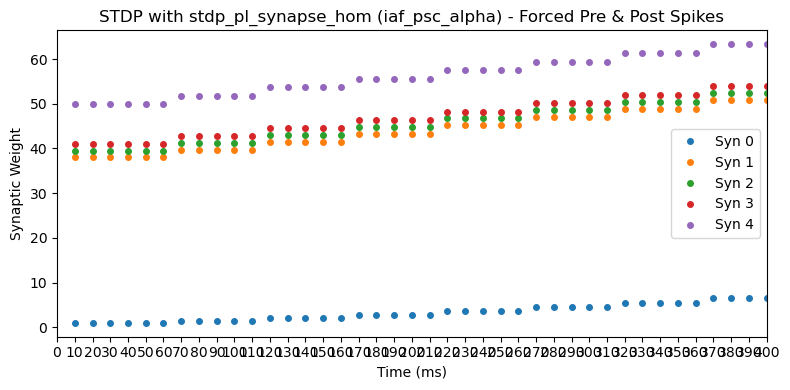

Saved synaptic weight plot to 'weights_alpha_forced_pl.png'


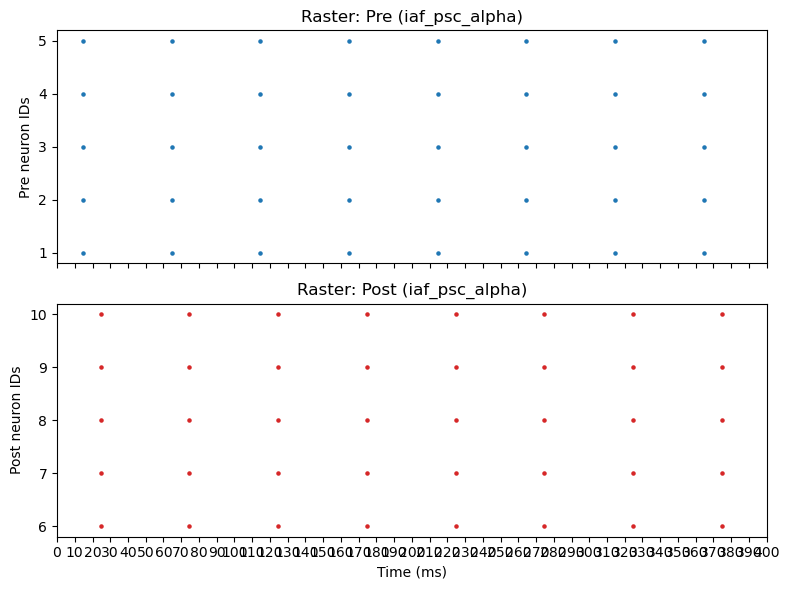

Saved spike raster to 'raster_alpha_forced_pl.png'


In [3]:
import os

def get_script_dir():
    try:
        # Works if we're running as a .py script
        return os.path.dirname(os.path.abspath(__file__))
    except NameError:
        # Fallback if __file__ is not defined (e.g. in Jupyter)
        return os.getcwd()

if __name__ == "__main__":
    current_dir = get_script_dir()
    config_file = os.path.join(current_dir, "config.yaml")
    run_stdp_alpha_forced_pl(config_file)
